In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot
import tensorflow as tf
from epi.SC_Circuit_8 import SC_acc_diff_var

### 1. Define the V1Circuit model

In [2]:
lb = -1.
ub = 1.

sW_P = Parameter("sW_P", 1, lb=lb, ub=ub)
sW_A = Parameter("sW_A", 1, lb=lb, ub=ub)

vW_PA = Parameter("vW_PA", 1, lb=lb, ub=ub)
vW_AP = Parameter("vW_AP", 1, lb=lb, ub=ub)

dW_PA = Parameter("dW_PA", 1, lb=lb, ub=ub)
dW_AP = Parameter("dW_AP", 1, lb=lb, ub=ub)

hW_P = Parameter("hW_P", 1, lb=lb, ub=ub)
hW_A = Parameter("hW_A", 1, lb=lb, ub=ub)

parameters = [sW_P, sW_A, vW_PA, vW_AP, dW_PA, dW_AP, hW_P, hW_A]

model = Model("SC_acc_diff", parameters)

In [3]:
model.set_eps(SC_acc_diff_var)
mu_std = 0.05

epi_df = model.get_epi_df()
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['mu_len'] = [ep['mu'].shape[0] for ep in epi_df['EP']]
epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
epi_df['random_seed'] = [arch['random_seed'] for arch in epi_df['arch']]

data/epi/SC_acc_diff/66940a8fc592aa16d5cf0717aac9b82b/D8_C3_L2_U50_bnmom=9.90E-01_PA_rs2/5f88b30190a889df73ca9cbdc6ac7856/N100_lr1.00E-03_c0=1.00E+01_gamma2.50E-01_beta4.00E+00


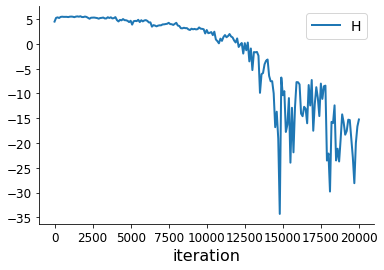

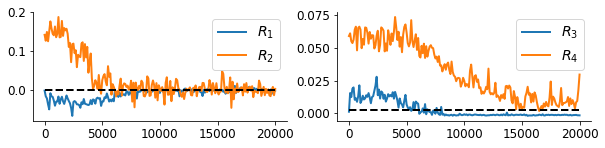

In [5]:
mu =  np.array([0., -0.25, mu_std**2, mu_std**2])
epi_df2 = epi_df[(epi_df['c0']==1e1) & (epi_df['mu_len'] == 4) 
                 & (epi_df['beta'] == 4.) & (epi_df['random_seed'] == 2)]


paths = sorted(epi_df2['path'].unique())
for i, path in enumerate(paths):
    print(path)
    epi_df2 = epi_df[epi_df['path'] == path]
    epi_df2.plot('iteration', 'H')
    plt.show()
    fig, axs = plt.subplots(1,2,figsize=(10,2))
    axs[0].plot(epi_df2['iteration'], epi_df2['R1'], label=r'$R_1$')
    axs[0].plot(epi_df2['iteration'], epi_df2['R2'], label=r'$R_2$')
    axs[0].plot([0, epi_df2['iteration'].max()], [mu[0], mu[0]], 'k--')
    axs[0].legend()
    axs[1].plot(epi_df2['iteration'], epi_df2['R3'], label=r'$R_3$')
    axs[1].plot(epi_df2['iteration'], epi_df2['R4'], label=r'$R_4$')
    axs[1].plot([epi_df2['iteration'].min(), epi_df2['iteration'].max()], [mu_std**2, mu_std**2], 'k--')
    axs[1].legend()
    plt.show()

In [6]:
path = paths[0]
best_k = 9

_epi_df = epi_df[epi_df['path'] == path]
df_row = _epi_df.iloc[0]
init = df_row['init']
init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
nf = model._df_row_to_nf(df_row)
aug_lag_hps = model._df_row_to_al_hps(df_row)

dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)
print('dist', dist)

dist <epi.models.Distribution object at 0x7fac1c767588>


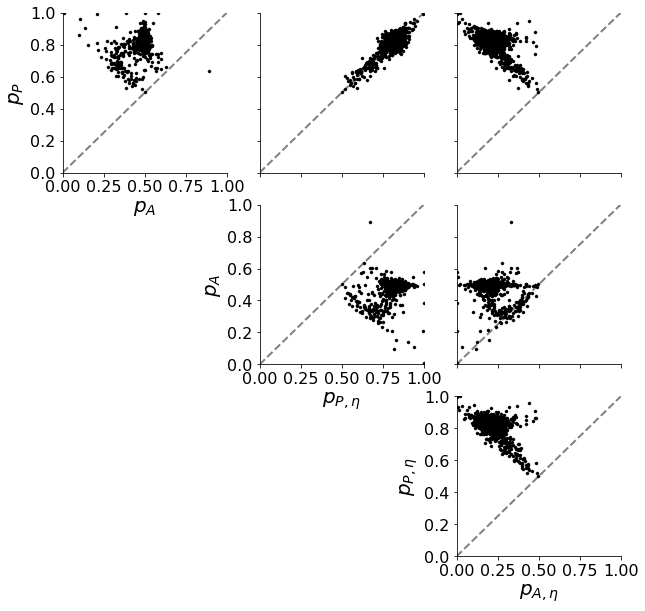

In [12]:
from epi.SC_Circuit_8 import SC_acc, unwrap
z, log_q_z = dist.nf(1000)
z = z.numpy()
log_q_z = log_q_z.numpy()

def plot_p(z):
    fontsize=20
    p = SC_acc(*unwrap(z)).numpy()
    p[:,1] = 1.-p[:,1]
    p[:,3] = 1.-p[:,3]
    p_labels = [r'$p_P$', r'$p_A$', r'$p_{P,\eta}$', r'$p_{A,\eta}$']
    fig, axs = pairplot(p, np.arange(4), p_labels,
                   fontsize=fontsize, figsize=(10,10),
                   lb=np.zeros((4,)), ub=np.ones((4,)))

    for i in range(3):
        for j in range(i,3):
            axs[i][j].plot([0,1], [0,1], 'k--', alpha=0.5)

plot_p(z)